In this notebook, we're going to talk about ***SHapley Additive exPlanations (SHAP)*** values. SHAP values are a model-agnostic way of calculating feature importance scores. Rather than looking at the internals of a model, they are inspired by the concept of Shapley values from cooperative game theory.

# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score

# Load the dataset
diabetes_dataset = datasets.load_diabetes(as_frame=True)
df = diabetes_dataset.frame

# Rename the features for clarity
df = df.rename(columns={'s1': 'total serum cholesterol',
                        's2': 'low-density lipoproteins',
                        's3': 'high-density lipoproteins',
                        's4': 'total cholesterol',
                        's5': 'log of serum triglycerides',
                        's6': 'blood sugar'})

In [3]:
def generate_regressor(orig_df):
    """
    Train and test a regression model on the input DataFrame, returning the
    regressor, the feature names, and a dictionary of all the relevant data
    orig_df: the input DataFrame
    """
    # Set random number generator so the results are always the same
    np.random.seed(42)

    # Get the names of the features
    feature_names = df.columns.tolist()
    feature_names.remove('target')

    # Split the data into train and test sets
    train_df, test_df = train_test_split(orig_df, test_size=0.2)

    # Separate features from labels
    x_train = train_df.drop('target', axis=1).values
    y_train = train_df['target'].values
    x_test = test_df.drop('target', axis=1).values
    y_test = test_df['target'].values

    # Create and train the model
    regr = LinearRegression()
    regr.fit(x_train, y_train)

    # Use the model to predict on the test set
    y_pred = regr.predict(x_test)

    # Create a nested dictionary of all the data for easier retrieval
    data = {'train': {'x': x_train, 'y': y_train},
            'test': {'x': x_test, 'y': y_test},
            'pred': {'x': x_test, 'y': y_pred}}
    return regr, feature_names, data

In [4]:
def generate_classifier(orig_df):
    """
    Train and test a classification model on the input DataFrame, returning the
    classifier, the feature names, and a dictionary of all the relevant data
    orig_df: the input DataFrame for regression
    """
    # Set random number generator so the results are always the same
    np.random.seed(42)

    # Copy the DataFrame since we will be modifying it
    df = orig_df.copy()

    # Get the names of the features
    feature_names = df.columns.tolist()
    feature_names.remove('target')

    # Turn the label into a binary variable
    df['target'] = df['target'] > 150

    # Split the data into train and test sets
    train_df, test_df = train_test_split(df, test_size=0.2)

    # Separate features from labels
    x_train = train_df.drop('target', axis=1).values
    y_train = train_df['target'].values
    x_test = test_df.drop('target', axis=1).values
    y_test = test_df['target'].values

    # Create and train the model
    clf = DecisionTreeClassifier()
    clf.fit(x_train, y_train)

    # Use the model to predict on the test set
    y_pred = clf.predict(x_test)

    # Create a nested dictionary of all the data for easier retrieval
    data = {'train': {'x': x_train, 'y': y_train},
            'test': {'x': x_test, 'y': y_test},
            'pred': {'x': x_test, 'y': y_pred}}
    return clf, feature_names, data

# An Illustrative Example

To illustrate the intuition behind SHAP values, we will walk through a hypothetical scenario that has nothing to do with machine learning.

Three friends – Alice, Bob, and Carlos – go out for a meal. They ordered and shared all of their dishes together and the bill came out to \$900. However, they they did not eat an equal amount of food, so doing an even split of \$300 each does not seem fair to them. How should they determine how much each person should pay?

If each person kept track of how much they ate, then they could simply pay according to the percentage of food that they ate. However, let's assume that nobody was counting french fries or pizza slices.

Instead, let's imagine that the friends talk through how much they would have collectively spent had they gone to dinner in different combinations. For example, if Alice went to dinner on her own, she would have spent \$800, but if Alice and Carlos went together, they would have spent \$850. Here are the outcomes of all possible combinations:

| People | Total Cost |
|--------|------------|
| Alice | \$800 |
| Bob | \$560 |
| Carlos | \$700 |
| Alice and Bob | \$800 |
| Alice and Carlos | \$850 |
| Bob and Carlos | \$720 |
| Alice, Bob, and Carlos | \$900 |


To determine the fairest split possible, we could determine how much each friend would pay if they were to be added to the group one at a time. For example, let's imagine that Alice, Bob, and Carlos were to pay in sequence. Alice would pay \$800. Since Alice and Bob would have spent the same amount together, Bob would not need to pay anything. Once Carlos gets added, he would need to pay \$100 to get the total to \$900. If we were to repeat this calculation for all possible combinations of friends, we would get the following payouts:

| Order | Payouts |
|-------|---------|
| Alice, Bob, Carlos | \$800 + \$0 + \$100 |
| Bob, Alice, Carlos | \$560 + \$240 + \$100 |
| Bob, Carlos, Alice | \$560 + \$160 + \$180 |
| Carlos, Alice, Bob | \$700 + \$150 + \$50 |
| Carlos, Bob, Alice | \$700 + \$20 + \$180 |
| Alice, Carlos, Bob | \$800 + \$50 + \$50 |

To determine how much each friend should pay, we would take the average of how much they would have spent across all possible scenarios:

| Friend | Fair Payment |
|--------|-----------|
| Alice | (\$800 + \$240 + \$180 + \$150 + \$180 + \$800) / 6 = \$392 |
| Bob | (\$0 + \$560 + \$560 + \$50 + \$20 + \$50) / 6 = \$207 |
| Carlos | (\$100 + \$100 + \$160 + \$700 + \$700 + \$50) / 6 = \$302 |

Conveniently enough, the total of these payments ends up being \$900 with a bit of rounding error.

# Translating the Illustrative Example to Machine Learning

In our toy example, the friends represent features and the total bill represents the prediction to which they are contributing. If we knew how much each feature contributed to the prediction (i.e., how much each person ate), we would have been able to figure out their contributions directly. This would be the equivalent of inspecting the internals of the model.

Instead, SHAP values allow us to treat the model as a black box. We simulate generating predictions using different combinations of features, and we use those results to calculate the contribution of each feature in the final prediction.

Here are the steps for calculating the SHAP value for a single feature $F$:

1. Create the set of all possible feature combinations called coalitions.
2. Calculate the model's average prediction across the entire training dataset. For a classification problem, the prediction is a continuous probability between 0 and 1. For a regression problem, the prediction is a continuous output variable.
3. For each coalition, calculate the difference between the model's prediction without $F$ and the average prediction.
4. For each coalition, calculate the difference between the model's prediction with $F$ and the average prediction.
5. For each coalition, calculate how much $F$ changed the model's prediction from the average (i.e., step 4 - step 3). This is the marginal contribution of F.
5. The SHAP value for $F$ is the average of all the values calculated in step 5 (i.e., the average of $F$'s marginal contributions)

Fortunately, we don't have to do this math ourselves. The `shap` library provides everything you need to calculate SHAP values for most models that are built with `scikit-learn`.

In [5]:
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.7 MB/s eta 0:00:00


SHAP values can either be generated to explain predictions on any subset of data: the training set, the test set, etc. However, we would be answering different questions about our model depending on which one we choose.

Looking at the training set would allow us to learn more about what the model learned, while looking at the test set would allow us to learn more about how the model will make decisions on unseen data. In the examples below, we will focus on the latter because it will better illustrate how SHAP values can provide interpretable explanations for model decisions.

# Visualizing SHAP Values for Individual Predictions (Regression)

One of the great things about SHAP values is that we can use them to explain how each feature contributes to a single prediction. This would allow us to answer questions like "Why did the model make this prediction for this specific input?".

Let's pretend that we want to see how each feature contributed to the prediction made on the first sample in the test set. To start, we will calculate the SHAP values associated with all of the samples in our test set:

In [6]:
# Get the regression model and its relevant information
regr, feature_names, data = generate_regressor(df)
x_test = data['test']['x']

# Generate the SHAP explainer
explainer = shap.Explainer(regr, x_test, feature_names=feature_names)

# Apply the SHAP explainer on our test set
shap_values = explainer(x_test)

print(f'Shape of the test set: {x_test.shape}')
print(f'Shape of the SHAP values: {shap_values.shape}')

Shape of the test set: (89, 10)
Shape of the SHAP values: (89, 10)


There are a couple of different ways we can visualize these SHAP values. We'll first look at a waterfall plot:

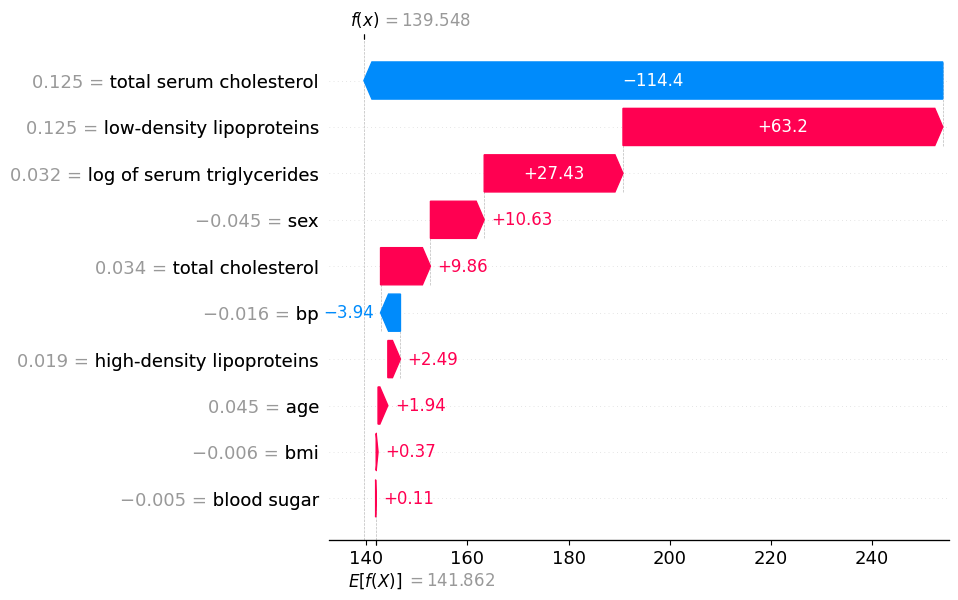

In [7]:
shap.plots.waterfall(shap_values[0])

Here is how we should interpret this graph:
* The average prediction of the model across the entire dataset is denoted at the bottom at $E[f(X)]$, also known as the expected value of the model.
* The prediction for this particular example is listed at the top as $f(X)$.
* The feature values associated with the sample we are investigating are shown along the left side of the screen. Remember that our features are normalized between -0.2 and 0.2, which is why some of the values seem a bit weird.
* The red and blue arrows within the graph indicate how each feature moves the prediction from the average prediction to the final result. Red arrows indicate positive contributions that increase the final result, and blue arrows indicate negative contributions that decrease the final result.
* The features are ordered from top-to-bottom in terms of the magnitude of their contribution.

The second graph will be a force graph, which shows similar information but on a single line. Unfortunately, this graph will not be very readable because we used long feature names, but hopefully you can see how it presents mostly the same information.

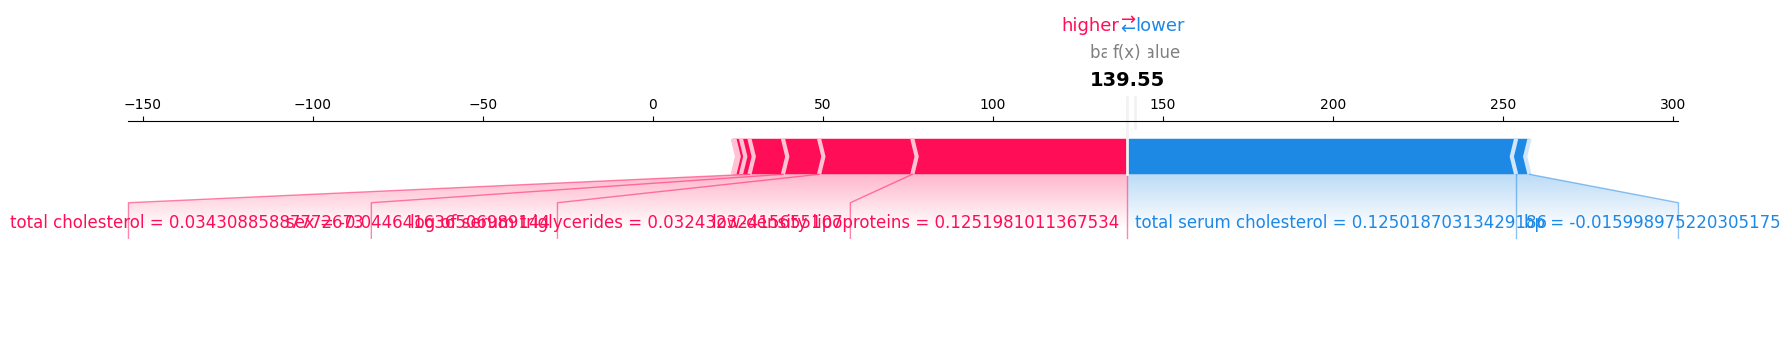

In [8]:
shap.force_plot(explainer.expected_value, shap_values.values[0],
                features=x_test[0], feature_names=feature_names, matplotlib=True)

So what can we learn from these graphs?
* It seems that total serum cholesterol has the biggest influence on the prediction for this sample, and it drives the prediction to be much lower than it would have been otherwise.
* Low-density lipoproteins and the log of serum triglycerides also have moderately strong, negative contributions on teh prediction.
* Features like age, BMI, and blood sugar seem to be negligible in this case.

# Visualizing SHAP Values for an Entire Dataset (Regression)

Looking at the SHAP values associated with an individual prediction is great, but different features might have different contributions on different predictions depending on the values of the features themselves. For example, total cholesterol may be extremely important for male patients but less important for female patients.

It can therefore be helpful to visualize the distribution of SHAP values for each feature across the entire test set. This would allow us to answer questions like "Which features are generally more important to the model?" and "Does this feature generally have a positive or negative impact on the prediction output?".

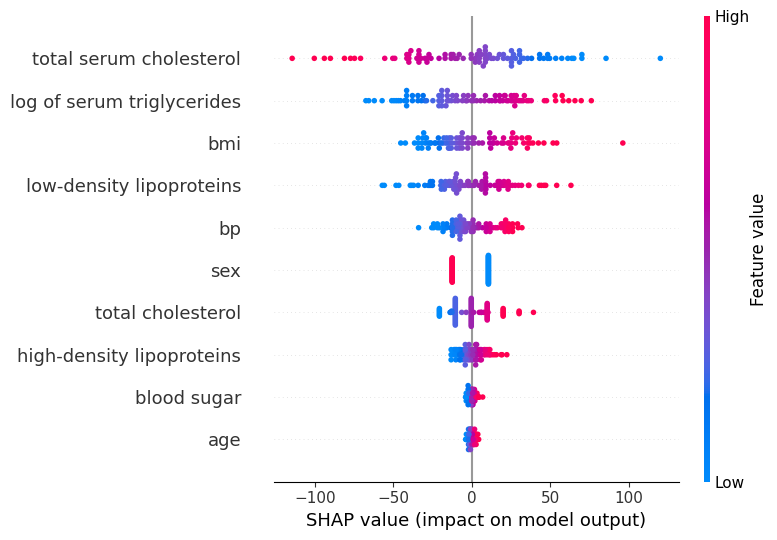

In [9]:
shap.summary_plot(shap_values, features=x_test, feature_names=feature_names)

Here is how we should interpret this graph:
* As with the waterfall plot, each row corresponds to a feature.
* Each dot within a row represents a single sample in our dataset. Therefore, each row should have the same number of dots.
* The color of each dot indicates the value of each feature relative to the rest of the dataset. Red dots indicate high feature values, while blue dots indicate low feature values.
* The horizontal position of each dot represents the contribution that feature had on the given prediction. Dots on the left had lower predictions because of the feature value associated with that sample, while dots on the right had higher predictions for the same reason.
* The vertical position of each dot within a given row has no meaning; this is strictly done so that the dots are more clearly visibile.


To clarify these rules further, let's iterate through some possible scenarios for feature $F$ in a sample $S$:

| Color of the Dot | Horizontal Position of the Dot | Interpretation |
|------------------|--------------------------------|----------------|
| Blue | Left | The value of $F$ in $S$ is low, leading to a lower prediction for $S$ |
| Blue | Middle | The value of $F$ in $S$ is low, but it has little influence on the prediction for $S$ |
| Blue | Right | The value of $F$ in $S$ is low, leading to a higher prediction for $S$ |
| Red | Left | The value of $F$ in $S$ is high, leading to a lower prediction for $S$ |
| Red | Middle | The value of $F$ in $S$ is high, but it has little influence on the prediction for $S$ |
| Red | Right | The value of $F$ in $S$ is high, leading to a higher prediction for $S$ |

When all of the colors are grouped together within a row, then we can be fairly confident that these trends uphold across the entire dataset.

So what can we learn from this graph?
* Total serum cholesterol has the biggest overall influence on predictions since it has the most dots at either horizontal extreme. However, it should be observed that there are many dots near the center of the graph, indicating that the feature may not have been the most influential for all predictions.
* Higher total serum cholesterol values generally led to lower predictions, while lower values generally led to higher predictions.
* Age and blood sugar seem to be the least important features for all of our dataset since the dots are generally at the center of the graph.

# Visualizing SHAP Values for Individual Predictions (Classification)

Up until this point, we've been looking at SHAP values for our regression model. Let's generate the same graphs as before, only this time for our classification model. We'll start with the visualization of an individual prediction.

In [10]:
# Get the classification model and its relevant information
clf, feature_names, data = generate_classifier(df)
x_test = data['test']['x']

# Generate the SHAP explainer
explainer = shap.Explainer(clf, x_test, feature_names=feature_names)

# Apply the SHAP explainer on our test set
shap_values = explainer(x_test)

print(f'Shape of the test set: {x_test.shape}')
print(f'Shape of the SHAP values: {shap_values.shape}')

Shape of the test set: (89, 10)
Shape of the SHAP values: (89, 10, 2)


Notice that the shape of the SHAP values array is different. This is because if a classification problem has more than two possible classes, it is important the we are able to attribute feature contributions towards each class.

In the case of a binary classifer like the one we have, `shap_values[:, :, 0] == -shap_values[:, :, 0]` since positive contributions toward a positive prediction are the same negative contributions toward a negative prediction. We will look at the SHAP values from the perspective of the positive class since that will be more intuitive.

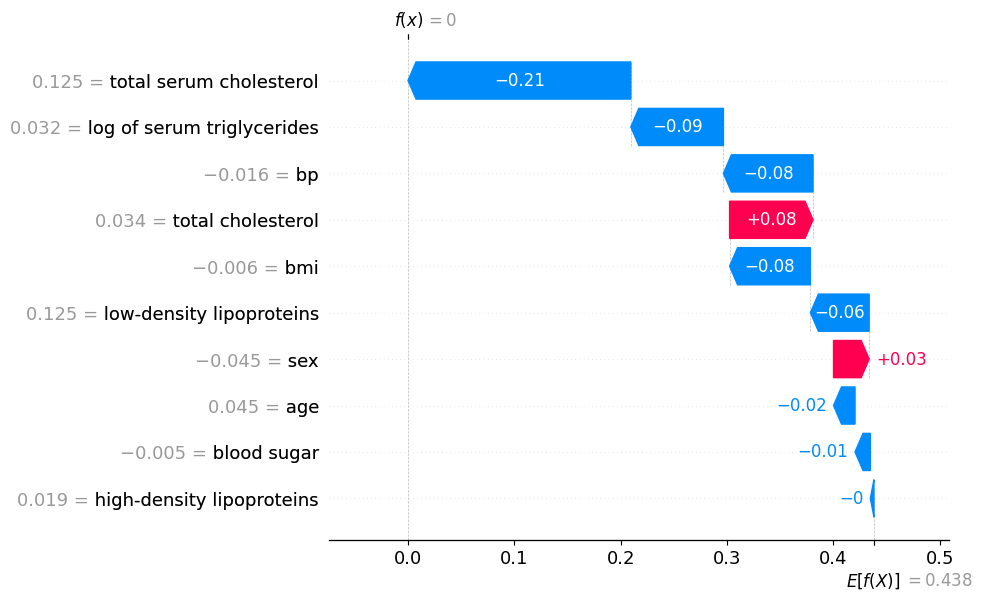

In [11]:
target_class = 1
shap.plots.waterfall(shap_values[0, :, target_class])

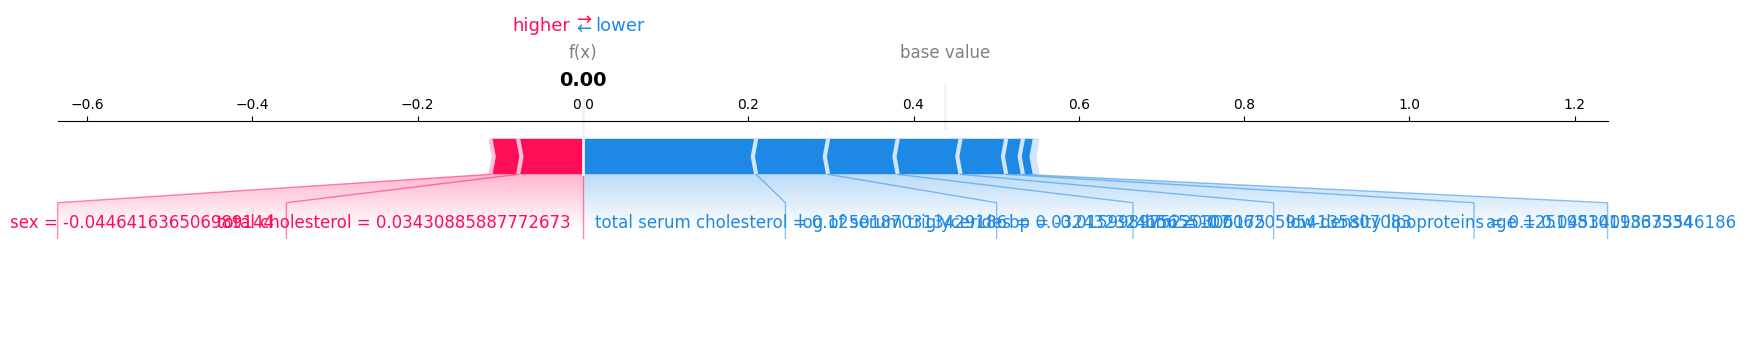

In [12]:
target_class = 1
shap.force_plot(explainer.expected_value[target_class], shap_values.values[0, :, target_class],
                features=x_test[0], feature_names=feature_names, matplotlib=True)

Recall that the labels of our classifier simply threshold the disease progression scores at 150, so lower regression scores are correlated with "lower" classification outcomes. Therefore, it makes sense that we would hopefully see similar trends as we did for our regression model. For example, total serum cholesterol has the biggest influence on the prediction for this sample, and it drives the prediction to be much lower than it would have been otherwise.

However, we also see that some of the contributions are flipped. For our regression model, low-density lipoproteins had a fairly positive contribution to our regression label, while it has a slightly negative contribtion to our classification model. This can be for a number of reasons: the structure of the models, the relative magnitude of the contributions, etc.

# Visualizing SHAP Values for an Entire Dataset (Classification)

Now let's look at the SHAP values for all of our dataset:

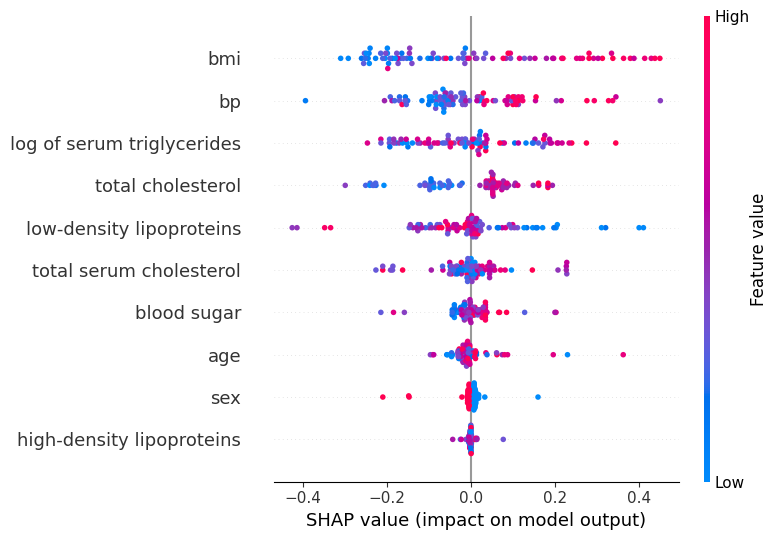

In [13]:
target_class = 1
shap.summary_plot(shap_values[:, :, target_class], features=x_test,
                  feature_names=feature_names)

Now things have gotten interesting. Notice that the colors of the dots are intermixed a bit more than they were with our regression model. This is primarily due to the structure of the models are using.

With a linear regression, feature values are multiplied by fixed coefficients, so increasing the value of feature $F$ will always have a monotonic (i.e., always increasing or decreasing) impact on its contribution to the prediction. This is not the case with a decision tree classifier. Imagine the first branch in the tree splits between high and low values of $F$. Both sides of the tree are likely to have scenarios where both positive and negative outcomes are possible, so the magnitude and direction of $F$'s contribution is not as clear cut.

Still, we can see some trends that generalize across most of the dataset:
* Higher BMIs are more likely to lead to positive predictions
* Lower low-density lipoproteins tend to lead to positive predictions as well